In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
@author: M Arshad Zahangir Chowdhury

Use a 1D convolutional neural network to train and test on simulated THz spectra and demonstrate overfit


"""

%matplotlib inline 

import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from ipywidgets import interactive
import seaborn as sns  #heat map
import glob # batch processing of images

if '../../' not in sys.path:
    sys.path.append('../../')

import math
from scipy import signal
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import itertools

from vocnet.misc.utils import classifier_internals
from vocnet.misc.utils import clf_post_processor




from vocnet.spectral_datasets.THz_datasets import THz_data

from vocnet.misc.aperture import publication_fig
from vocnet.misc.voc_net_utils import multiclass_roc_auc_score
from vocnet.misc.voc_net_utils import plot_raw_scores
from vocnet.misc.voc_net_utils import simple_spectrum_fig
from vocnet.misc.voc_net_utils import simple_plot_raw_scores



import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# GPU_mem_limit=1.0
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])

#     except RuntimeError as e:
#         print(e)        

#         #Set random seed
tf.random.set_seed(42)  


# !pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import regularizers

from vocnet.models.voc_net_models import get_callbacks
from vocnet.models.voc_net_models import get_optimizer
from vocnet.models.voc_net_models import compile_and_fit


# from vocnet.models.voc_net_models import simplest_model
# from vocnet.models.voc_net_models import simplest_with_max_pool_model
# from vocnet.models.voc_net_models import multi_conv_model
# from vocnet.models.voc_net_models import multi_conv_with_dense_model
# from vocnet.models.voc_net_models import multi_conv_with_second_pool_model
# from vocnet.models.voc_net_models import multi_conv_with_dense_multi_filter_model
# from vocnet.models.voc_net_models import multi_conv_with_dense_multi_filter_bottleneck_model
# from vocnet.models.voc_net_models import simplest_reg_dropout_model

from vocnet.models.voc_net_models import C1f1k3_AP1_D12
from vocnet.models.voc_net_models import C1f1k3_MP1_D12

from vocnet.models.voc_net_models import C2f1k3_AP1_D12
from vocnet.models.voc_net_models import C2f1k3_AP1_D48_D12
from vocnet.models.voc_net_models import C2f1k3_AP2_D48_D12

from vocnet.models.voc_net_models import C2f3k3_AP1_D48_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D6_D12

from vocnet.models.voc_net_models import C1f1k3_AP1_RD50_D12
from vocnet.models.voc_net_models import C1f1k3_AP1_D48_RL1_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D48_RD50_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D48_RL1_D12
from vocnet.models.voc_net_models import C2f3k3_AP1_D48_RL1_RD50_D12

    


2022-07-19 11:12:43.343460: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# functions and class definitions should be here and moved

In [2]:


# # function for scoring roc auc score for multi-class
# def multiclass_roc_auc_score(y_test, y_pred, target, average="macro", figsize = (12, 8), dpi=300 ):
#     lb = LabelBinarizer()
#     lb.fit(y_test)
#     y_test = lb.transform(y_test)
#     y_pred = lb.transform(y_pred)
    
#     fig, c_ax = plt.subplots(1,1, figsize = figsize, dpi=dpi)

#     for (idx, c_label) in enumerate(target):
#         fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
#         c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
#     c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')    
#     c_ax.legend()
#     c_ax.set_xlabel('False Positive Rate')
#     c_ax.set_ylabel('True Positive Rate')

#     plt.close()
    
#     return roc_auc_score(y_test, y_pred, average=average), fig, c_ax


# def plot_raw_scores(i, predictions_array, true_label, all_unique_labels, 
#                     fig_prop = {'figsize':(2,0.7), 'dpi':300, 'ax_rect': [0,0,1,1]}
#                    ):
#     fig = plt.figure(figsize=fig_prop['figsize'],dpi=fig_prop['dpi'])
#     ax = fig.add_axes(fig_prop['ax_rect'])
    
#     true_label = true_label[i]
#     plt.grid(False)
#     plt.xticks(range(12),all_unique_labels)
#     plt.yticks([])
#     thisplot = plt.bar(range(12), predictions_array[i], color="#777777")
#     plt.ylim([0, 1])
#     ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
#     predicted_label = np.argmax(predictions_array[i])
    
#     ax.set_xticklabels(s.labels);
#     ax.set_xlabel('Labels', labelpad = 4, 
#                   fontsize = 'small', 
#                   fontweight = 'bold')
#     ax.set_ylabel('Softmax scores', labelpad = 4, 
#                   fontsize = 'small', 
#                   fontweight = 'bold')
#     ax.xaxis.set_tick_params(which='major', 
#                              size=5, 
#                              width=1, 
#                              direction='out',
#                              labelsize=7)
#     ax.yaxis.set_tick_params(which='major', 
#                              size=5, 
#                              width=1, 
#                              direction='out',
#                              labelsize=7)
    
    
    
#     plt.xticks(rotation=90, fontweight='bold');

#     thisplot[predicted_label].set_color('red')
#     thisplot[true_label].set_color('blue')
#     plt.close()
#     return fig, ax


# def simple_spectrum_fig(frequencies, absorbances):
    
#     spectrum_plot = plt.plot(frequencies, absorbances/max(absorbances), linewidth = 0.5, color = 'black')
#     plt.xlabel('Frequency ($cm^{-1}$)')
#     plt.ylabel('Norm. Abs.')
#     plt.xlim([frequencies[0], frequencies[-1]])
    
# def simple_plot_raw_scores(i, predictions_array, true_label,all_unique_labels):
    
#     true_label = true_label[i]
#     plt.grid(False)
#     plt.yticks(range(12),all_unique_labels)

#     scoreplot = plt.barh(range(12), predictions_array[i], color="#777777")
    
#     plt.xlim([0, 1])
#     predicted_label = np.argmax(predictions_array[i])
#     plt.yticks(fontsize = 7);
#     plt.tick_params(axis = 'y', direction = 'out') # , pad =-335
    
#     plt.ylabel('label')
#     plt.xlabel('softmax score')
#     scoreplot[predicted_label].set_color('red')
#     scoreplot[true_label].set_color('blue')
    
    
    

## load THz spectra

In [3]:
s = THz_data(resolution=0.016, verbosity = False)
s.load_THz_data()

## attributes of the THz dataset

In [4]:
# s.dataset_info()

## visualize the THz spectra

In [5]:
def f_spectra(spectra_no):
    plt.plot(s.frequencies, s.spectra[spectra_no]); #reshape needed so you have 367 datapoints.
#     plt.ylim(-0.5, 5)
    plt.grid(True)
    plt.show()

interactive_plot = interactive(f_spectra, spectra_no=(0, s.spectra.shape[0]-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=983, description='spectra_no', max=1967), Output()), _dom_classes=('widg…

# choose amount of data

In [6]:

# s.filter_by_index(0,51)

# X_filtered=s.filtered_spectra
# y_filtered=s.filtered_targets

## Assigning the data to the model
expand the dimension of the data 


In [7]:
X = s.spectra
y = s.targets

# X = X_filtered
# y = y_filtered

In [8]:
X.shape

(1968, 229)

In [9]:
X=np.expand_dims(X,-1)

In [10]:
X.shape

(1968, 229, 1)

In [11]:
#split intro train and test set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

TRAIN_SIZE=0.70
TEST_SIZE=1-TRAIN_SIZE

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                   stratify=y
                                                   )

print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Testing:", np.bincount(y_test) / float(len(y_test))*100  )


All: [8.33333333 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333
 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333]
Training: [8.35148874 8.35148874 8.35148874 8.35148874 8.35148874 8.35148874
 8.35148874 8.2788671  8.35148874 8.35148874 8.2788671  8.2788671 ]
Testing: [8.29103215 8.29103215 8.29103215 8.29103215 8.29103215 8.29103215
 8.29103215 8.46023689 8.29103215 8.29103215 8.46023689 8.46023689]


# get validation data

In [12]:

s.load_experiments()
Xexp = s.exp_spectra
yexp = s.exp_targets
SpectraFrame = pd.DataFrame(s.exp_spectra)
SpectraFrame['labels'] = [s.labels[i] for i in s.exp_targets]
SpectraFrame['targets'] =  s.exp_targets
spectraframe = SpectraFrame 
Xexp = np.expand_dims(Xexp,-1)
print(yexp)

print(s.labels)
print([s.labels[i] for i in s.exp_targets])

Number of Experimental Compounds: 6
Number of Spectrum: 6
Total Number of Spectra: 36
Sample Size of training data: 229
Rows discarded: 22
[10 10 10 10 10 10  2  2  2  2  2  2  1  1  1  1  1  1  0  0  0  0  0  0
  8  8  8  8  8  8 11 11 11 11 11 11]
['CH3Cl', 'CH3OH', 'HCOOH', 'H2CO', 'H2S', 'SO2', 'OCS', 'HCN', 'CH3CN', 'HNO3', 'C2H5OH', 'CH3CHO']
['C2H5OH', 'C2H5OH', 'C2H5OH', 'C2H5OH', 'C2H5OH', 'C2H5OH', 'HCOOH', 'HCOOH', 'HCOOH', 'HCOOH', 'HCOOH', 'HCOOH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3OH', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3Cl', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CN', 'CH3CHO', 'CH3CHO', 'CH3CHO', 'CH3CHO', 'CH3CHO', 'CH3CHO']


## define 1D CNN model architecture

In [13]:
s.samplesize

229

# Create model via a sequential stack of layers using the layers API with the add() method

In [14]:
x_test.shape

(591, 229, 1)

In [15]:
N_TEST = x_test.shape[0]
N_TRAIN = x_train.shape[0]
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
print(STEPS_PER_EPOCH)

13


In [16]:
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.001,
#   decay_steps=STEPS_PER_EPOCH*1,
#   decay_rate=1,
#   staircase=False)

# def get_optimizer():
#     return tf.keras.optimizers.Adam(lr_schedule)



In [17]:
# step = np.linspace(0,100)
# lr = lr_schedule(step)
# plt.figure(figsize = (8,6))
# plt.plot(step/STEPS_PER_EPOCH, lr)
# plt.ylim([0,max(plt.ylim())])
# plt.xlabel('Epoch')
# _ = plt.ylabel('Learning Rate')

In [18]:
size_histories = {}

# select model
model = C1f1k3_AP1_D12()

size_histories['C1f1k3_AP1_D12'] = compile_and_fit(model, 'sizes/C1f1k3_AP1_D12', 
                                             x_train, 
                                             y_train, 
                                             x_test, 
                                             y_test, 
                                             STEPS_PER_EPOCH,  
                                             optimizer=None, 
                                             max_epochs=200)

2022-07-19 11:13:04.581076: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-19 11:13:04.612865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-07-19 11:13:04.612946: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-19 11:13:04.618747: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-19 11:13:04.618874: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-07-19 11:13:04.620051: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 1)            0         
_________________________________________________________________
flatten (Flatten)            (None, 113)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1368      
Total params: 1,372
Trainable params: 1,372
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
__________________________________

2022-07-19 11:13:05.277864: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-07-19 11:13:05.278057: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:13:05.330530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-19 11:13:05.348763: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz
2022-07-19 11:13:05.766542: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-19 11:13:06.014712: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2022-07-19 11:13:06.473564: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcubl

2022-07-19 11:13:07.152368: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:13:07.186189: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C1f1k3_AP1_D12/train/plugins/profile/2022_07_19_11_13_07
2022-07-19 11:13:07.186751: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpefpaslyz/tensorboard_logs/sizes/C1f1k3_AP1_D12/train/plugins/profile/2022_07_19_11_13_07/Galileo.trace.json.gz
2022-07-19 11:13:07.242547: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C1f1k3_AP1_D12/train/plugins/profile/2022_07_19_11_13_07
2022-07-19 11:13:07.244006: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/tmpefpaslyz/tensorboard_logs/sizes/C1f1k3_AP1_D12/train/plugins/profile/2022_07_1


Epoch: 0, SparseCatCrossentropy:2.4995,  accuracy:0.1140,  loss:2.4995,  val_SparseCatCrossentropy:2.4910,  val_accuracy:0.1523,  val_loss:2.4911,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.4529,  accuracy:0.9521,  loss:0.4529,  val_SparseCatCrossentropy:0.4271,  val_accuracy:0.9594,  val_loss:0.4269,  
....................................................................................................

In [19]:
model = C1f1k3_MP1_D12()
size_histories['C1f1k3_MP1_D12'] = compile_and_fit(model, 'sizes/C1f1k3_MP1_D12', 
                                               x_train, 
                                               y_train, 
                                               x_test, 
                                               y_test, 
                                               STEPS_PER_EPOCH,  
                                               optimizer=None, 
                                               max_epochs=200)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (MaxPooling1D)            (None, 113, 1)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 113)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1368      
Total params: 1,372
Trainable params: 1,372
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
______________________________

2022-07-19 11:13:44.253338: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:13:44.253374: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:13:44.253502: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:13:44.253718: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:13:44.591723: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:13:44.591757: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:13:44.591926: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:13:44.625498: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:13:44.626149: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:13:44.626610: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:13:44.627299: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C1f1k3_MP1


Epoch: 0, SparseCatCrossentropy:2.3861,  accuracy:0.2527,  loss:2.3862,  val_SparseCatCrossentropy:2.3530,  val_accuracy:0.3350,  val_loss:2.3528,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.2435,  accuracy:0.9731,  loss:0.2435,  val_SparseCatCrossentropy:0.2327,  val_accuracy:0.9797,  val_loss:0.2319,  
....................................................................................................

In [20]:
model = C2f1k3_AP1_D12()
size_histories['C2f1k3_AP1_D12'] = compile_and_fit(model, 'sizes/C2f1k3_AP1_D12', 
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None, 
                                                          max_epochs=200)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 1)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 1)            4         
_________________________________________________________________
flatten_2 (Flatten)          (None, 111)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1344      
Total params: 1,352
Trainable params: 1,352
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 O

2022-07-19 11:14:04.931209: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:14:04.931237: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:14:04.931286: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:14:04.931363: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:14:05.362694: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:14:05.362722: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:14:05.362853: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:14:05.400692: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:14:05.401413: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:14:05.401885: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:14:05.402608: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f1k3_AP1


Epoch: 0, SparseCatCrossentropy:2.4613,  accuracy:0.1874,  loss:2.4614,  val_SparseCatCrossentropy:2.4462,  val_accuracy:0.2876,  val_loss:2.4460,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.1009,  accuracy:0.9891,  loss:0.1009,  val_SparseCatCrossentropy:0.0984,  val_accuracy:0.9915,  val_loss:0.0978,  
....................................................................................................

In [21]:
model = C2f1k3_AP1_D48_D12()
size_histories['C2f1k3_AP1_D48_D12'] = compile_and_fit(model, 'sizes/C2f1k3_AP1_D48_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None, 
                                                          max_epochs=200)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 1)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 1)            4         
_________________________________________________________________
flatten_3 (Flatten)          (None, 111)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                5376      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                588       
Total params: 5,972
Trainable params: 5,972
Non-trainable params: 0
____________________________________________________

2022-07-19 11:14:28.889692: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:14:28.889718: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:14:28.889831: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:14:28.889848: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:14:29.241788: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:14:29.241811: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:14:29.241857: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:14:29.275109: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:14:29.275858: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:14:29.276516: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:14:29.277330: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f1k3_AP1


Epoch: 0, SparseCatCrossentropy:2.4851,  accuracy:0.0712,  loss:2.4851,  val_SparseCatCrossentropy:2.4849,  val_accuracy:0.0829,  val_loss:2.4849,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:2.4850,  accuracy:0.0704,  loss:2.4850,  val_SparseCatCrossentropy:2.4849,  val_accuracy:0.0829,  val_loss:2.4849,  
....................................................................................................

In [22]:


model = C2f1k3_AP2_D48_D12()
size_histories['C2f1k3_AP2_D48_D12'] = compile_and_fit(model, 'sizes/C2f1k3_AP2_D48_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None, 
                                                          max_epochs=200)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 1)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 1)            4         
_________________________________________________________________
S4 (AveragePooling1D)        (None, 55, 1)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 55)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 48)                2688      
_________________________________________________________________
dense_6 (Dense)              (None, 12)               

2022-07-19 11:14:53.319725: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:14:53.319755: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:14:53.320105: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:14:53.320228: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:14:53.695035: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:14:53.695058: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:14:53.695116: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:14:53.728282: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:14:53.729084: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:14:53.729566: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:14:53.730277: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f1k3_AP2


Epoch: 0, SparseCatCrossentropy:2.4569,  accuracy:0.1111,  loss:2.4569,  val_SparseCatCrossentropy:2.4281,  val_accuracy:0.1658,  val_loss:2.4276,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.0288,  accuracy:0.9978,  loss:0.0288,  val_SparseCatCrossentropy:0.0333,  val_accuracy:0.9983,  val_loss:0.0327,  
....................................................................................................

In [23]:
model = C2f3k3_AP1_D48_D12()
size_histories['C2f3k3_AP1_D48_D12'] = compile_and_fit(model, 'sizes/C2f3k3_AP1_D48_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None, 
                                                          max_epochs=200)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 3)            12        
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 3)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 3)            30        
_________________________________________________________________
flatten_5 (Flatten)          (None, 333)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 48)                16032     
_________________________________________________________________
dense_8 (Dense)              (None, 12)                588       
Total params: 16,662
Trainable params: 16,662
Non-trainable params: 0
__________________________________________________

2022-07-19 11:15:18.290731: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:15:18.290759: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:15:18.290808: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:15:18.290889: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:15:18.736000: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:15:18.736033: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:15:18.736169: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:15:18.771836: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:15:18.772679: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:15:18.773166: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:15:18.773893: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f3k3_AP1


Epoch: 0, SparseCatCrossentropy:2.4290,  accuracy:0.2527,  loss:2.4291,  val_SparseCatCrossentropy:2.3280,  val_accuracy:0.4890,  val_loss:2.3275,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.0167,  accuracy:0.9985,  loss:0.0167,  val_SparseCatCrossentropy:0.0199,  val_accuracy:0.9983,  val_loss:0.0198,  
....................................................................................................

In [24]:
model = C2f3k3_AP1_D6_D12()
size_histories['C2f3k3_AP1_D6_D12'] = compile_and_fit(model, 'sizes/C2f3k3_AP1_D6_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None, 
                                                          max_epochs=200)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 3)            12        
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 3)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 3)            30        
_________________________________________________________________
flatten_6 (Flatten)          (None, 333)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 2004      
_________________________________________________________________
dense_10 (Dense)             (None, 12)                84        
Total params: 2,130
Trainable params: 2,130
Non-trainable params: 0
____________________________________________________

2022-07-19 11:15:45.037277: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:15:45.037308: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:15:45.037435: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:15:45.037578: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:15:45.388701: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:15:45.388725: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:15:45.388773: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:15:45.422281: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:15:45.423162: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:15:45.423647: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:15:45.424359: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f3k3_AP1


Epoch: 0, SparseCatCrossentropy:2.4772,  accuracy:0.1772,  loss:2.4772,  val_SparseCatCrossentropy:2.4689,  val_accuracy:0.0829,  val_loss:2.4690,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.0253,  accuracy:0.9978,  loss:0.0253,  val_SparseCatCrossentropy:0.0265,  val_accuracy:0.9966,  val_loss:0.0262,  
....................................................................................................

# regularized models with both L2 and dropout regularization.
# what is the equation of the loss function?

Loss = Sparse Cross Entropy + L2 + Dropout 

Fix equation below

$J(\textbf{w}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \text{log}(\hat{y}_i) + (1-y_i) \text{log}(1-\hat{y}_i) \right] $


In [25]:
model = C1f1k3_AP1_RD50_D12()
size_histories['C1f1k3_AP1_RD50_D12'] = compile_and_fit(model, 'sizes/C1f1k3_AP1_RD50_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None,
                                                          max_epochs=200
                                                          )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 1)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 113)               0         
_________________________________________________________________
dropout (Dropout)            (None, 113)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                1368      
Total params: 1,372
Trainable params: 1,372
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 O

2022-07-19 11:16:11.634082: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:16:11.634114: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:16:11.634252: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:16:11.634373: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:16:12.116973: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:16:12.117001: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:16:12.117061: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:16:12.146409: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:16:12.147086: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:16:12.147547: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:16:12.148242: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C1f1k3_AP1


Epoch: 0, SparseCatCrossentropy:2.3415,  accuracy:0.1845,  loss:2.3416,  val_SparseCatCrossentropy:2.2085,  val_accuracy:0.3046,  val_loss:2.2089,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.2941,  accuracy:0.9702,  loss:0.2941,  val_SparseCatCrossentropy:0.1930,  val_accuracy:0.9898,  val_loss:0.1915,  
....................................................................................................

In [26]:
model = C1f1k3_AP1_D48_RL1_D12()
size_histories['C1f1k3_AP1_D48_RL1_D12'] = compile_and_fit(model, 'sizes/C1f1k3_AP1_D48_RL1_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None,
                                                          max_epochs=200
                                                          )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 1)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 113)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 48)                5472      
_________________________________________________________________
dense_13 (Dense)             (None, 12)                588       
Total params: 6,064
Trainable params: 6,064
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 O

2022-07-19 11:16:33.178154: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:16:33.178183: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:16:33.178307: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:16:33.178533: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:16:33.543041: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:16:33.543193: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:16:33.543292: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:16:33.588973: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:16:33.589755: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:16:33.590245: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:16:33.590961: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C1f1k3_AP1


Epoch: 0, SparseCatCrossentropy:2.4046,  accuracy:0.1525,  loss:3.2393,  val_SparseCatCrossentropy:2.2322,  val_accuracy:0.4129,  val_loss:3.0204,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.3314,  accuracy:0.9528,  loss:0.7411,  val_SparseCatCrossentropy:0.3173,  val_accuracy:0.9695,  val_loss:0.7262,  
....................................................................................................

In [27]:
model = C2f3k3_AP1_D48_RD50_D12()
size_histories['C2f3k3_AP1_D48_RD50_D12'] = compile_and_fit(model, 'sizes/C2f3k3_AP1_D48_RD50_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None,
                                                          max_epochs=200
                                                          )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 3)            12        
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 3)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 3)            30        
_________________________________________________________________
flatten_9 (Flatten)          (None, 333)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 48)                16032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)               

2022-07-19 11:16:56.208808: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:16:56.208835: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:16:56.208952: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:16:56.209156: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:16:56.582279: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:16:56.582302: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:16:56.582348: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:16:56.616192: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:16:56.617057: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:16:56.617534: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:16:56.618298: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f3k3_AP1


Epoch: 0, SparseCatCrossentropy:2.4216,  accuracy:0.2716,  loss:2.4217,  val_SparseCatCrossentropy:2.3412,  val_accuracy:0.5550,  val_loss:2.3408,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.0301,  accuracy:0.9920,  loss:0.0301,  val_SparseCatCrossentropy:0.0153,  val_accuracy:1.0000,  val_loss:0.0152,  
....................................................................................................

In [28]:
model = C2f3k3_AP1_D48_RL1_D12()
size_histories['C2f3k3_AP1_D48_RL1_D12'] = compile_and_fit(model, 'sizes/C2f3k3_AP1_D48_RL1_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None,
                                                          max_epochs=200
                                                          )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 3)            12        
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 3)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 3)            30        
_________________________________________________________________
flatten_10 (Flatten)         (None, 333)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 48)                16032     
_________________________________________________________________
dense_17 (Dense)             (None, 12)                588       
Total params: 16,662
Trainable params: 16,662
Non-trainable params: 0
_________________________________________________

2022-07-19 11:17:22.986161: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:17:22.986189: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:17:22.986237: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:17:22.986314: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:17:23.360217: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:17:23.360241: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:17:23.360375: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:17:23.394818: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:17:23.395689: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:17:23.396186: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:17:23.396913: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f3k3_AP1


Epoch: 0, SparseCatCrossentropy:2.2908,  accuracy:0.3602,  loss:3.2543,  val_SparseCatCrossentropy:2.1391,  val_accuracy:0.4365,  val_loss:3.0069,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.1147,  accuracy:0.9855,  loss:0.2853,  val_SparseCatCrossentropy:0.1134,  val_accuracy:0.9915,  val_loss:0.2828,  
....................................................................................................

In [29]:
model = C2f3k3_AP1_D48_RL1_RD50_D12()
size_histories['C2f3k3_AP1_D48_RL1_RD50_D12'] = compile_and_fit(model, 'sizes/C2f3k3_AP1_D48_RL1_RD50_D12',
                                                          x_train, 
                                                          y_train, 
                                                          x_test, 
                                                          y_test, 
                                                          STEPS_PER_EPOCH,  
                                                          optimizer=None,
                                                          max_epochs=200
                                                          )

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 3)            12        
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 3)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 3)            30        
_________________________________________________________________
flatten_11 (Flatten)         (None, 333)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 48)                16032     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 12)              

2022-07-19 11:17:49.958294: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:17:49.958322: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:17:49.958368: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:17:49.958449: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2022-07-19 11:17:50.352298: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-19 11:17:50.352326: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-19 11:17:50.352397: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-19 11:17:50.387881: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-19 11:17:50.388816: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-19 11:17:50.389319: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-19 11:17:50.390041: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpefpaslyz/tensorboard_logs/sizes/C2f3k3_AP1


Epoch: 0, SparseCatCrossentropy:2.4490,  accuracy:0.1467,  loss:3.3728,  val_SparseCatCrossentropy:2.3905,  val_accuracy:0.5448,  val_loss:3.1961,  
....................................................................................................
Epoch: 100, SparseCatCrossentropy:0.1363,  accuracy:0.9789,  loss:0.3422,  val_SparseCatCrossentropy:0.0895,  val_accuracy:0.9932,  val_loss:0.2939,  
....................................................................................................

In [30]:
# exclude certain models

print('all model names:', size_histories.keys())

model_histories = size_histories.copy()

# model_histories.pop('multi_conv_with_dense_multi_filter_bottleneck',)

print('all model names:', model_histories.keys())

all model names: dict_keys(['C1f1k3_AP1_D12', 'C1f1k3_MP1_D12', 'C2f1k3_AP1_D12', 'C2f1k3_AP1_D48_D12', 'C2f1k3_AP2_D48_D12', 'C2f3k3_AP1_D48_D12', 'C2f3k3_AP1_D6_D12', 'C1f1k3_AP1_RD50_D12', 'C1f1k3_AP1_D48_RL1_D12', 'C2f3k3_AP1_D48_RD50_D12', 'C2f3k3_AP1_D48_RL1_D12', 'C2f3k3_AP1_D48_RL1_RD50_D12'])
all model names: dict_keys(['C1f1k3_AP1_D12', 'C1f1k3_MP1_D12', 'C2f1k3_AP1_D12', 'C2f1k3_AP1_D48_D12', 'C2f1k3_AP2_D48_D12', 'C2f3k3_AP1_D48_D12', 'C2f3k3_AP1_D6_D12', 'C1f1k3_AP1_RD50_D12', 'C1f1k3_AP1_D48_RL1_D12', 'C2f3k3_AP1_D48_RD50_D12', 'C2f3k3_AP1_D48_RL1_D12', 'C2f3k3_AP1_D48_RL1_RD50_D12'])


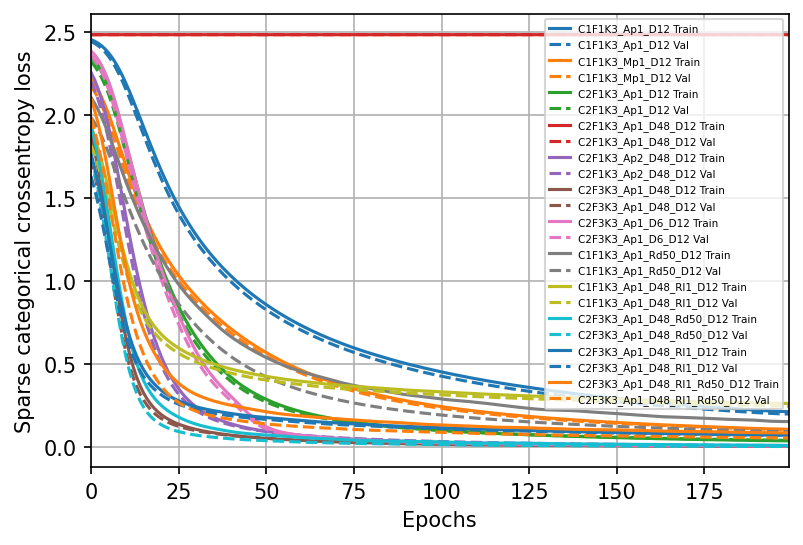

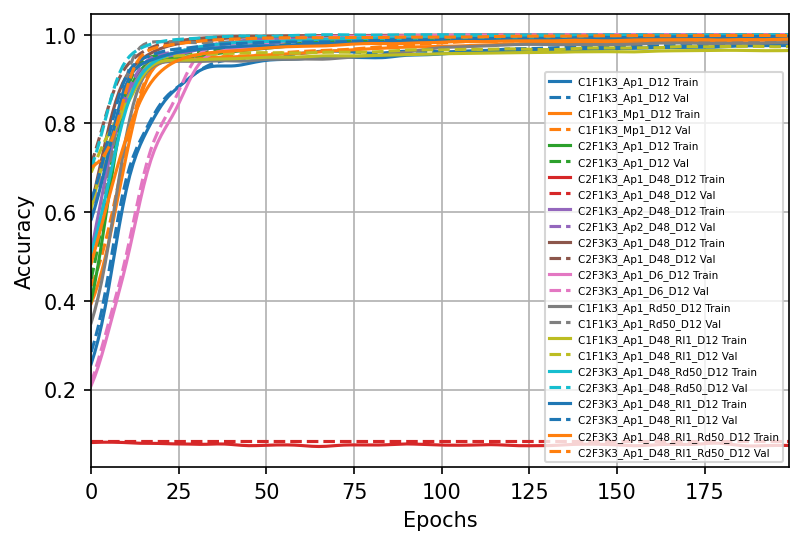

In [31]:
plt.figure(dpi=150)
plotter = tfdocs.plots.HistoryPlotter(metric = 'SparseCatCrossentropy', smoothing_std=10)
plotter.plot(model_histories)
# plt.ylim([0.5, 0.7])
plt.legend(loc=1,prop={'size': 5})
plt.ylabel('Sparse categorical crossentropy loss')
plt.savefig(r'RESULTS/results_figures/All_models_loss_sparse_cat.png', bbox_inches='tight')

plt.figure(dpi=150)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(model_histories)
plt.legend(loc=0,prop={'size': 5})
plt.ylabel('Accuracy')

plt.savefig(r'RESULTS/results_figures/All_models_accuray.png', bbox_inches='tight')

In [32]:
# exclude certain models

print('all model names:', size_histories.keys())

model_histories = size_histories.copy()

model_histories.pop('C2f1k3_AP1_D48_D12')

# print('all model names:', model_histories.keys())

all model names: dict_keys(['C1f1k3_AP1_D12', 'C1f1k3_MP1_D12', 'C2f1k3_AP1_D12', 'C2f1k3_AP1_D48_D12', 'C2f1k3_AP2_D48_D12', 'C2f3k3_AP1_D48_D12', 'C2f3k3_AP1_D6_D12', 'C1f1k3_AP1_RD50_D12', 'C1f1k3_AP1_D48_RL1_D12', 'C2f3k3_AP1_D48_RD50_D12', 'C2f3k3_AP1_D48_RL1_D12', 'C2f3k3_AP1_D48_RL1_RD50_D12'])


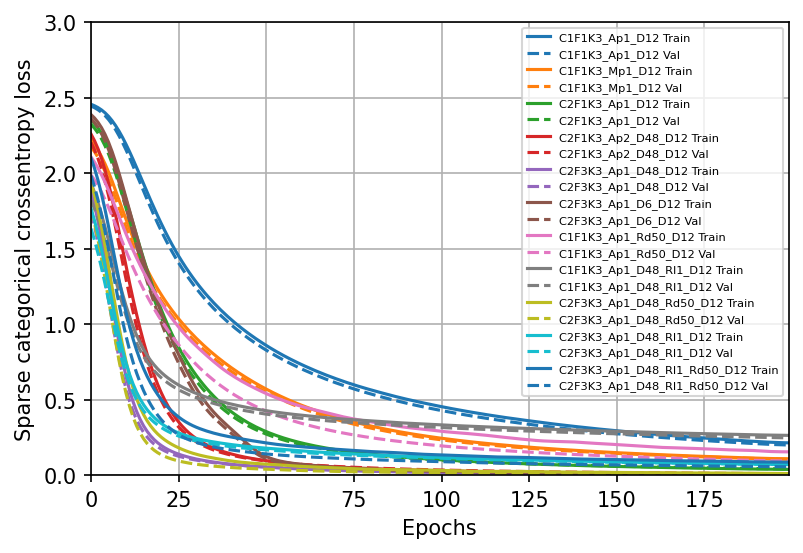

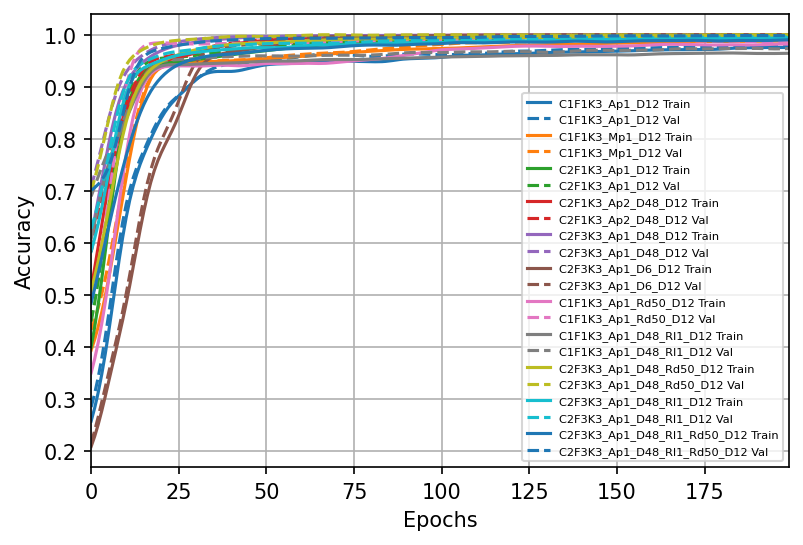

In [44]:
plt.figure(dpi=150)
plotter = tfdocs.plots.HistoryPlotter(metric = 'SparseCatCrossentropy', smoothing_std=10)
plotter.plot(model_histories)
plt.ylim([0, 3])
plt.legend(loc=1,prop={'size': 5.45})
plt.ylabel('Sparse categorical crossentropy loss')
plt.savefig(r'RESULTS/results_figures/All_models_loss_sparse_cat.png', bbox_inches='tight')

plt.figure(dpi=150)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(model_histories)
plt.legend(loc=0,prop={'size': 5.45})
plt.ylabel('Accuracy')

plt.savefig(r'RESULTS/results_figures/All_models_accuray.png', bbox_inches='tight')

### evaluate the accuracies at 200 epoch

In [52]:
for key in model_histories:
    
    a = model_histories[key].history['accuracy'][199]
    print(f'model name : {key} 200-epoch accuracy : {a}')
    

model name : C1f1k3_AP1_D12 200-epoch accuracy : 0.9782134890556335
model name : C1f1k3_MP1_D12 200-epoch accuracy : 0.9883805513381958
model name : C2f1k3_AP1_D12 200-epoch accuracy : 0.9985475540161133
model name : C2f1k3_AP2_D48_D12 200-epoch accuracy : 1.0
model name : C2f3k3_AP1_D48_D12 200-epoch accuracy : 0.9985475540161133
model name : C2f3k3_AP1_D6_D12 200-epoch accuracy : 0.9992737770080566
model name : C1f1k3_AP1_RD50_D12 200-epoch accuracy : 0.9803921580314636
model name : C1f1k3_AP1_D48_RL1_D12 200-epoch accuracy : 0.9636892080307007
model name : C2f3k3_AP1_D48_RD50_D12 200-epoch accuracy : 0.9978213310241699
model name : C2f3k3_AP1_D48_RL1_D12 200-epoch accuracy : 0.9956427216529846
model name : C2f3k3_AP1_D48_RL1_RD50_D12 200-epoch accuracy : 0.9905591607093811


In [43]:
model_histories['C1f1k3_AP1_D12'].history['accuracy'][199]

0.9782134890556335

In [35]:
model.layers[0].trainable_weights

[<tf.Variable 'C1/kernel:0' shape=(3, 1, 3) dtype=float32, numpy=
 array([[[ 1.1484404,  1.1347015, -1.7065552]],
 
        [[ 1.4586614,  1.5811542, -2.7200832]],
 
        [[ 1.5324428,  1.2872019, -2.3007638]]], dtype=float32)>,
 <tf.Variable 'C1/bias:0' shape=(3,) dtype=float32, numpy=array([0.3808197 , 0.39333427, 0.5317502 ], dtype=float32)>]

In [ ]:
from tensorflow.keras import backend as K
# with a Sequential model
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
# layer_output = get_1st_layer_output(x_test)
layer_output = get_1st_layer_output(X)

In [ ]:
model.layers[0].get_config()

In [ ]:
layer_output[0].shape

In [ ]:
layer_output[0][0].shape

In [ ]:
layer_output[0][0].shape

In [ ]:
j=0
plt.plot(X[j])
plt.plot(layer_output[0][j])

# training accuracies vs epoch

In [ ]:
# model.save('VOCNet')
history =size_histories['simplest'].history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)

print('\nTrain accuracy:', train_acc)

The model has achieved 100% accuracy. which is good but I wonder whether it is overfitting. I need to check and verify this. But first check the scores.

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(x_test)


In [ ]:
predictions[5]

In [ ]:

# high quality
i=4;

fig_score, ax_score = plot_raw_scores(i, predictions, y_test, s.labels)
fig_spectra, ax_spectra  = publication_fig(s.frequencies, 
                   x_test[i], 
                   xlim_low=s.frequencies[0],
                   xlim_high=s.frequencies[-1]+0.01, 
                   ylim_low=0,
                   ylim_high=1.00,
                   fig_prop = {'figsize':(2,0.7), 'dpi':300, 'ax_rect': [0,0,1,1]},
                   plot_prop = {'linewidth':0.25, 'color':'black' , 'fontweight':'bold', 'label' : 'compound'},
                   legend_prop = {'loc':2, 'size':3},
                   major_tick_params =  {'which':'major', 'size':6, 'width':1, 'direction':'out','labelsize':7},
                   minor_tick_params =  {'which':'minor', 'size':2, 'width':1, 'direction':'out','labelsize':7},
                   tick_locator = {'xmajor':0.5, 'xminor':1.5, 'ymajor':0.2, 'yminor':0.4},
                   xlabelinfo = {'xlabel': r'Frequency, $\nu$ ($cm^{-1}$)', 'labelpad':4, 'fontsize':'small', 'fontweight':'bold'}, 
                   ylabelinfo = {'ylabel': r'Norm. Abs.', 'labelpad':4, 'fontsize':'small', 'fontweight':'bold'},
                   twin_xlabelinfo = {'xlabel': 'Wavelength ($mm$)', 'labelpad':4, 'fontsize':'small', 'fontweight':'bold'}, 
                   plot_flags = {'twinx': True, 'legend':False}
                   );


print(y_test[i])

fig_score
fig_spectra

In [ ]:
i=3
# simple_spectrum_fig(s.frequencies, x_test[i])
simple_plot_raw_scores(i, predictions, y_test,s.labels)

In [ ]:
plot_sequential_group_prediction(x_test, y_test, predictions, 0)

In [ ]:
plot_sequential_group_prediction(x_test, y_test, predictions, 50)

# Make predictions and plot confusion matrix

In [ ]:
# make predictions
pred_y=np.argmax(model.predict(x_test), axis=-1)

In [ ]:
# clf_post_processor(rounded_pred_y, y_test, s.labels, cm_title='Confusion matrix CNN on IR Data', cmap_color='crest', verbose = True)

In [ ]:
cm = confusion_matrix(y_test, pred_y)
#print(cm)
fig = plt.figure(figsize=(16,10), dpi = 600);
plt.title('Confusion matrix 1D CNN on THz Data');
ax = sns.heatmap(cm, annot=True, cmap='PiYG');   #cmap='coolwarm' also good
#ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
ax.set_xticklabels(s.labels);
ax.set_yticklabels(s.labels);
plt.xlabel('Predicted Molecule');
plt.ylabel('Actual Moelcule');
plt.xticks(rotation=90);
plt.yticks(rotation=0);

## Specifically identify the misclassifications. Need to check if model is overfitting or underfitting

In [ ]:
classifier_internals(pred_y, y_test, y_train, 'simple_CNN')

In [ ]:
plot_sequential_group_prediction(x_test, y_test, predictions, 440)

# ROC Curve

In [ ]:
s.labels

# ROC on simulation

In [ ]:

print('ROC AUC score:', multiclass_roc_auc_score(y_test, pred_y, s.labels)[0])

multiclass_roc_auc_score(y_test, pred_y, s.labels)[1]

### calculate ROC on experiments too

# Add experimental classification and calculation of TPR, FPR etc.  Integrate the CNN classifier to the old THz experimental classification notebook.

In [ ]:
s.load_experiments()
Xexp = s.exp_spectra
yexp = s.exp_targets
SpectraFrame = pd.DataFrame(s.exp_spectra)
SpectraFrame['labels'] = [s.labels[i] for i in s.exp_targets]
SpectraFrame['targets'] =  s.exp_targets
spectraframe = SpectraFrame 
Xexp = np.expand_dims(Xexp,-1)

print(yexp)
print(s.labels)
print(s.exp_)
print([s.labels[i] for i in s.exp_targets])

In [ ]:
pred_y_exp=np.argmax(model.predict(Xexp), axis=-1)
print(pred_y_exp)


In [ ]:
predictions_exp = probability_model.predict(Xexp) # softmax scores for experiment


In [ ]:
# cm = confusion_matrix(yexp, pred_y_exp)
# #print(cm)
# fig = plt.figure(figsize=(16,10), dpi = 600);
# plt.title('Confusion matrix 1D CNN on experimental THz Data');
# ax = sns.heatmap(cm, annot=True, cmap='PiYG');   #cmap='coolwarm' also good
# #ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
# ax.set_xticklabels(s.labels);
# ax.set_yticklabels(s.labels);
# plt.xlabel('Predicted Molecule');
# plt.ylabel('Actual Moelcule');
# plt.xticks(rotation=90);
# plt.yticks(rotation=0);

In [ ]:
plot_sequential_group_prediction(Xexp, yexp, predictions_exp, 23)

In [ ]:
# import the experimental ROC curves from the THz work.
# print('ROC AUC score:', multiclass_roc_auc_score(yexp, pred_y_exp, s.exp_targets)[0])

multiclass_roc_auc_score(yexp, pred_y_exp, s.labels)[1]

# demonstrate overfitting

show simple, moderate and very complex models


# add dropout, early stopping and L2 regualrization to mitigate overfitting and pick model from there

## notebook ends